# Full Halo Analysis

### Creating a Catalog

Here we put everything together to perform some realistic analysis. First we load a full simulation dataset.

In [1]:
import yt
from yt.extensions.astro_analysis.halo_analysis.api import *
import tempfile
import shutil
import os

# Create temporary directory for storing files
tmpdir = tempfile.mkdtemp()

# Load the data set with the full simulation information
data_ds = yt.load('Enzo_64/RD0006/RedshiftOutput0006')

yt : [INFO     ] 2017-08-10 16:18:30,826 Parameters: current_time              = 646.75066015177
yt : [INFO     ] 2017-08-10 16:18:30,826 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2017-08-10 16:18:30,827 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-08-10 16:18:30,829 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-08-10 16:18:30,830 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-08-10 16:18:30,830 Parameters: current_redshift          = 0
yt : [INFO     ] 2017-08-10 16:18:30,831 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2017-08-10 16:18:30,831 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2017-08-10 16:18:30,832 Parameters: hubble_constant           = 0.71


Now we load a rockstar halos binary file. This is the output from running the rockstar halo finder on the dataset loaded above. It is also possible to require the HaloCatalog to find the halos in the full simulation dataset at runtime by specifying a `finder_method` keyword.

In [2]:
# Load the rockstar data files
halos_ds = yt.load('rockstar_halos/halos_0.0.bin')

yt : [INFO     ] 2017-08-10 16:18:33,351 Parameters: current_time              = 4.183955192777767e+17 s
yt : [INFO     ] 2017-08-10 16:18:33,351 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-08-10 16:18:33,353 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-08-10 16:18:33,353 Parameters: domain_right_edge         = [ 128.  128.  128.]
yt : [INFO     ] 2017-08-10 16:18:33,355 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-08-10 16:18:33,355 Parameters: current_redshift          = 0.0013931104659006266
yt : [INFO     ] 2017-08-10 16:18:33,356 Parameters: omega_lambda              = 0.699999988079071
yt : [INFO     ] 2017-08-10 16:18:33,357 Parameters: omega_matter              = 0.30000001192092896
yt : [INFO     ] 2017-08-10 16:18:33,358 Parameters: hubble_constant           = 0.7099999785423279


From these two loaded datasets we create a halo catalog object. No analysis is done at this point, we are simply defining an object we can add analysis tasks to. These analysis tasks will be run in the order they are added to the halo catalog object.

In [3]:
# Instantiate a catalog using those two parameter files
hc = HaloCatalog(data_ds=data_ds, halos_ds=halos_ds, 
                 output_dir=os.path.join(tmpdir, 'halo_catalog'))

yt : [INFO     ] 2017-08-10 16:18:35,348 Allocating for 2.960e+02 particles (index particle type 'all')
yt : [INFO     ] 2017-08-10 16:18:35,355 Identified 8.100e+01 octs


The first analysis task we add is a filter for the most massive halos; those with masses great than $10^{14}~M_\odot$. Note that all following analysis will only be performed on these massive halos and we will not waste computational time calculating quantities for halos we are not interested in. This is a result of adding this filter first. If we had called `add_filter` after some other `add_quantity` or `add_callback` to the halo catalog, the quantity and callback calculations would have been performed for all halos, not just those which pass the filter.

In [4]:
# Filter out less massive halos
hc.add_filter("quantity_value", "particle_mass", ">", 1e14, "Msun")

### Finding Radial Profiles

Our first analysis goal is going to be constructing radial profiles for our halos. We would like these profiles to be in terms of the virial radius. Unfortunately we have no guarantee that values of center and virial radius recorded by the halo finder are actually physical. Therefore we should recalculate these quantities ourselves using the values recorded by the halo finder as a starting point.

The first step is going to be creating a sphere object that we will create radial profiles along. This attaches a sphere data object to every halo left in the catalog.

In [5]:
# attach a sphere object to each halo whose radius extends to twice the radius of the halo
hc.add_callback("sphere", factor=2.0)

Next we find the radial profile of the gas overdensity along the sphere object in order to find the virial radius. `radius` is the axis along which we make bins for the radial profiles. `[("gas","overdensity")]` is the quantity that we are profiling. This is a list so we can profile as many quantities as we want. The `weight_field` indicates how the cells should be weighted, but note that this is not a list, so all quantities will be weighted in the same way. The `accumulation` keyword indicates if the profile should be cummulative; this is useful for calculating profiles such as enclosed mass. The `storage` keyword indicates the name of the attribute of a halo where these profiles will be stored. Setting the storage keyword to "virial_quantities_profiles" means that the profiles will be stored in a dictionary that can be accessed by `halo.virial_quantities_profiles`.

In [6]:
# use the sphere to calculate radial profiles of gas density weighted by cell volume in terms of the virial radius
hc.add_callback("profile", ["radius"],
                [("gas", "overdensity")],
                weight_field="cell_volume", 
                accumulation=True,
                storage="virial_quantities_profiles")

Now we calculate the virial radius of halo using the sphere object. As this is a callback, not a quantity, the virial radius will not be written out with the rest of the halo properties in the final halo catalog. This also has a `profile_storage` keyword to specify where the radial profiles are stored that will allow the callback to calculate the relevant virial quantities. We supply this keyword with the same string we gave to `storage` in the last `profile` callback.

In [7]:
# Define a virial radius for the halo.
hc.add_callback("virial_quantities", ["radius"], 
                profile_storage = "virial_quantities_profiles")

Now that we have calculated the virial radius, we delete the profiles we used to find it.

In [8]:
hc.add_callback('delete_attribute','virial_quantities_profiles')

Now that we have calculated virial quantities we can add a new sphere that is aware of the virial radius we calculated above.

In [9]:
hc.add_callback('sphere', radius_field='radius_200', factor=5,
                field_parameters=dict(virial_radius=('quantity', 'radius_200')))

Using this new sphere, we calculate a gas temperature profile along the virial radius, weighted by the cell mass.

In [10]:
hc.add_callback('profile', 'virial_radius_fraction', [('gas','temperature')],
                storage='virial_profiles',
                weight_field='cell_mass', 
                accumulation=False, output_dir='profiles')


As profiles are not quantities they will not automatically be written out in the halo catalog; thus in order to be reloadable we must write them out explicitly through a callback of `save_profiles`. This makes sense because they have an extra dimension for each halo along the profile axis. 

In [11]:
# Save the profiles
hc.add_callback("save_profiles", storage="virial_profiles", output_dir="profiles")

We then create the halo catalog. Remember, no analysis is done before this call to create. By adding callbacks and filters we are simply queuing up the actions we want to take that will all run now.

In [12]:
hc.create()

Parsing Hierarchy : 100%|██████████| 749/749 [00:00<00:00, 32681.41it/s]
yt : [INFO     ] 2017-08-10 16:18:48,122 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2017-08-10 16:18:48,985 Calculating 1D profile for halo 0.
/Users/britton/Documents/work/yt/extensions/yt_astro_analysis/yt_astro_analysis/halo_analysis/halo_callbacks.py:247: VisibleDeprecationWarning: 
profile.variance incorrectly returns the profile standard deviation and has 
been deprecated, use profile.standard_deviation instead.
  if hasattr(my_profile, "variance"):
/Users/britton/Documents/work/yt/extensions/yt_astro_analysis/yt_astro_analysis/halo_analysis/halo_callbacks.py:249: VisibleDeprecationWarning: 
profile.variance incorrectly returns the profile standard deviation and has 
been deprecated, use profile.standard_deviation instead.
  for field in my_profile.variance])
yt : [INFO     ] 2017-08-10 16:18:49,016 Calculating virial quantities for halo 0.
yt : [INFO     ] 2017-08-10 16:18:49,018 Calc

### Reloading HaloCatalogs

Finally we load these profiles back in and make a pretty plot. It is not strictly necessary to reload the profiles in this notebook, but we show this process here to illustrate that this step may be performed completely separately from the rest of the script. This workflow allows you to create a single script that will allow you to perform all of the analysis that requires the full dataset. The output can then be saved in a compact form where only the necessarily halo quantities are stored. You can then download this smaller dataset to a local computer and run any further non-computationally intense analysis and design the appropriate plots.

We can load a previously saved halo catalog by using the `load` command. We then create a `HaloCatalog` object from just this dataset.

In [13]:
halos_ds =  yt.load(os.path.join(tmpdir, 'halo_catalog/halo_catalog.0.h5'))

hc_reloaded = HaloCatalog(halos_ds=halos_ds,
                          output_dir=os.path.join(tmpdir, 'halo_catalog'))

yt : [INFO     ] 2017-08-10 16:18:57,145 Parameters: current_time              = 4.183955192777767e+17 s
yt : [INFO     ] 2017-08-10 16:18:57,146 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-08-10 16:18:57,147 Parameters: domain_left_edge          = [ 0.  0.  0.] code_length
yt : [INFO     ] 2017-08-10 16:18:57,148 Parameters: domain_right_edge         = [ 128.  128.  128.] code_length
yt : [INFO     ] 2017-08-10 16:18:57,150 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-08-10 16:18:57,150 Parameters: current_redshift          = 0.0013931104659
yt : [INFO     ] 2017-08-10 16:18:57,151 Parameters: omega_lambda              = 0.699999988079
yt : [INFO     ] 2017-08-10 16:18:57,152 Parameters: omega_matter              = 0.300000011921
yt : [INFO     ] 2017-08-10 16:18:57,152 Parameters: hubble_constant           = 0.709999978542
yt : [INFO     ] 2017-08-10 16:18:57,159 Allocating for 4.700e+01 particles (index particle type 'all')
yt : [INFO    

 Just as profiles are saved seperately throught the `save_profiles` callback they also must be loaded separately using the `load_profiles` callback.

In [14]:
hc_reloaded.add_callback('load_profiles', storage='virial_profiles',
                         output_dir='profiles')

Calling `load` is the equivalent of calling `create` earlier, but defaults to to not saving new information. This means that the callback to `load_profiles` is not run until we call `load` here.

In [16]:
hc_reloaded.load()

yt : [INFO     ] 2017-08-10 16:19:19,079 Loading halo 0 profile data from /var/folders/s_/syw8wdg56xv93gcyhzl4h3q40000gn/T/tmpy9yix3ks/halo_catalog/profiles/virial_profiles_000000.h5.
yt : [INFO     ] 2017-08-10 16:19:19,084 Loading halo 2 profile data from /var/folders/s_/syw8wdg56xv93gcyhzl4h3q40000gn/T/tmpy9yix3ks/halo_catalog/profiles/virial_profiles_000002.h5.
yt : [INFO     ] 2017-08-10 16:19:19,089 Loading halo 5 profile data from /var/folders/s_/syw8wdg56xv93gcyhzl4h3q40000gn/T/tmpy9yix3ks/halo_catalog/profiles/virial_profiles_000005.h5.
yt : [INFO     ] 2017-08-10 16:19:19,094 Loading halo 6 profile data from /var/folders/s_/syw8wdg56xv93gcyhzl4h3q40000gn/T/tmpy9yix3ks/halo_catalog/profiles/virial_profiles_000006.h5.
yt : [INFO     ] 2017-08-10 16:19:19,098 Loading halo 7 profile data from /var/folders/s_/syw8wdg56xv93gcyhzl4h3q40000gn/T/tmpy9yix3ks/halo_catalog/profiles/virial_profiles_000007.h5.
yt : [INFO     ] 2017-08-10 16:19:19,102 Loading halo 9 profile data from /var/f

### Plotting Radial Profiles

In the future ProfilePlot will be able to properly interpret the loaded profiles of `Halo` and `HaloCatalog` objects, but this functionality is not yet implemented. In the meantime, we show a quick method of viewing a profile for a single halo.

The individual `Halo` objects contained in the `HaloCatalog` can be accessed through the `halo_list` attribute. This gives us access to the dictionary attached to each halo where we stored the radial profiles.

In [17]:
halo = hc_reloaded.halo_list[0]

radius = halo.virial_profiles[u"('index', 'virial_radius_fraction')"]
temperature = halo.virial_profiles[u"('gas', 'temperature')"]

# Remove output files, that are no longer needed
shutil.rmtree(tmpdir)

Here we quickly use matplotlib to create a basic plot of the radial profile of this halo. When `ProfilePlot` is properly configured to accept Halos and HaloCatalogs the full range of yt plotting tools will be accessible.

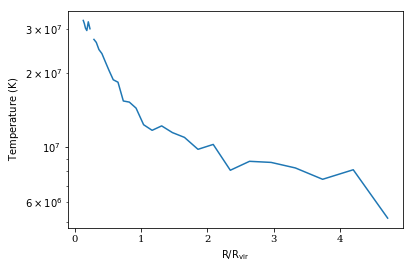

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(radius), np.array(temperature))

plt.semilogy()
plt.xlabel(r'$\rm{R/R_{vir}}$')
plt.ylabel(r'$\rm{Temperature\/\/(K)}$')

plt.show()